In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Input
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("NumPy version:", np.__version__)



TensorFlow version: 2.17.1
Keras version: 3.5.0
NumPy version: 1.26.4


In [4]:

# Check if GPU is detected
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices}")
else:
    print("No GPU detected.")


GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Loading

In [5]:
# Define dataset paths
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
photo_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Function to load and decode images
def load_jpeg_images(path):
    image_files = tf.io.gfile.glob(path + "/*.jpg")  # Get all image paths
    dataset = tf.data.Dataset.from_tensor_slices(image_files)

    # Function to load and decode an image
    def load_and_preprocess_image(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG (RGB)
        image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize [0,1]
        return image

    dataset = dataset.map(load_and_preprocess_image)  # Apply function
    return dataset

# Load datasets
monet_ds = load_jpeg_images(monet_path)
photo_ds = load_jpeg_images(photo_path)

# Print a sample image shape
for img in monet_ds.take(1):
    print("Image shape:", img.shape)


Image shape: (256, 256, 3)


In [ ]:
# Plot the first 12 images
plt.figure(figsize=(12, 6))
for i, img in enumerate(monet_ds.take(12)):
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns
    plt.imshow(img.numpy())  # Convert tensor to numpy array
    plt.axis("off")

plt.tight_layout()
plt.show()

# EDA

## Data Overview

In [ ]:

# Count number of images in each dataset
num_monet = len(os.listdir(monet_path))
num_photos = len(os.listdir(photo_path))

print(f"Number of Monet paintings: {num_monet}")
print(f"Number of real photos: {num_photos}")


In [ ]:

# Load a single image to check its shape
sample_monet = next(iter(monet_ds.take(1))).numpy()
sample_photo = next(iter(photo_ds.take(1))).numpy()

print(f"Monet Image Shape: {sample_monet.shape}")
print(f"Photo Image Shape: {sample_photo.shape}")

##  Histogram of RGB Values in Monet's Paintings

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


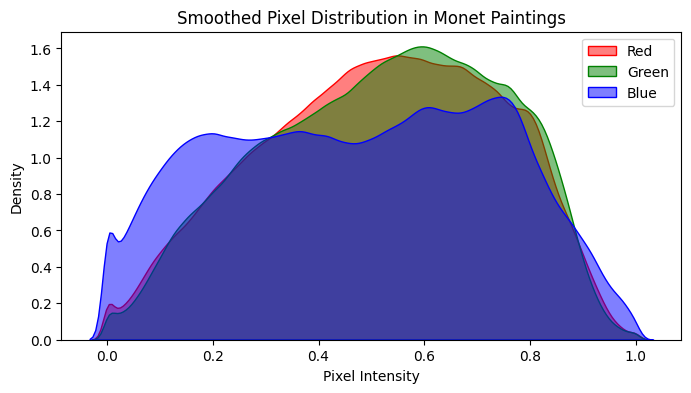

In [9]:

def plot_smooth_pixel_distribution(dataset, title):
    all_pixels_r, all_pixels_g, all_pixels_b = [], [], []

    for img in dataset.take(100):  # Sample 100 images
        img = img.numpy()
        all_pixels_r.extend(img[:, :, 0].flatten())  # Red channel
        all_pixels_g.extend(img[:, :, 1].flatten())  # Green channel
        all_pixels_b.extend(img[:, :, 2].flatten())  # Blue channel

    # Convert lists to Pandas Series (automatically handles NaN)
    df_r = pd.Series(all_pixels_r)
    df_g = pd.Series(all_pixels_g)
    df_b = pd.Series(all_pixels_b)

    # Remove Inf values (Seaborn doesn't like them)
    df_r.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_g.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_b.replace([np.inf, -np.inf], np.nan, inplace=True)

    plt.figure(figsize=(8, 4))
    
    # Smooth using KDE (Kernel Density Estimation)
    sns.kdeplot(df_r.dropna(), color='red', label="Red", fill=True, alpha=0.5)
    sns.kdeplot(df_g.dropna(), color='green', label="Green", fill=True, alpha=0.5)
    sns.kdeplot(df_b.dropna(), color='blue', label="Blue", fill=True, alpha=0.5)
    
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot smoothed pixel distributions for Monet paintings
plot_smooth_pixel_distribution(monet_ds, "Smoothed Pixel Distribution in Monet Paintings")


* Blue dominates over Red & Green: Monet paintings use cooler tones, especially blues.
* Peaks in Green and Red at mid-intensity (~0.6): Suggests warm highlights exist in some areas (like sunsets or trees).
* More uniform distribution across colors


## Brightness

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


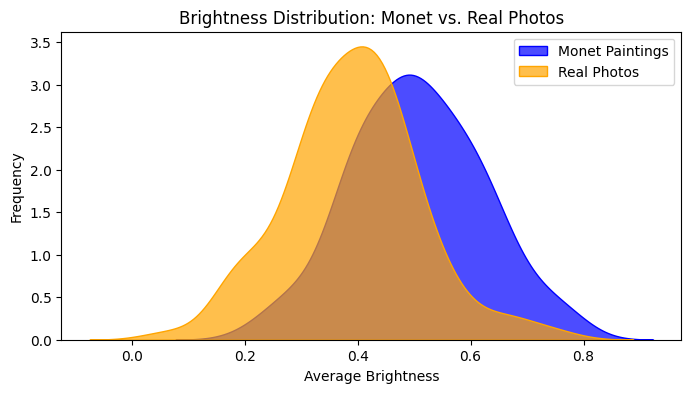

In [10]:
def compute_brightness(img):
    return np.mean(img.numpy())  # Compute mean pixel value (brightness)

monet_brightness = [compute_brightness(img) for img in monet_ds.take(100)]
photo_brightness = [compute_brightness(img) for img in photo_ds.take(100)]

# Plot brightness comparison
plt.figure(figsize=(8, 4))
sns.kdeplot(monet_brightness,alpha=0.7,fill=True, label="Monet Paintings", color='blue')
sns.kdeplot(photo_brightness,alpha=0.7,fill=True, label="Real Photos", color='orange')
plt.xlabel("Average Brightness")
plt.ylabel("Frequency")
plt.legend()
plt.title("Brightness Distribution: Monet vs. Real Photos")
plt.show()


* The Monet brightness curve is more concentrated, meaning Monet paintings have similar, consistent brightness levels.
* The real photo curve is wider, meaning real-world images have more variation in lighting conditions.

In [11]:
def compute_mean_rgb(dataset):
    mean_r, mean_g, mean_b = [], [], []

    for img in dataset.take(100):
        img = img.numpy()
        mean_r.append(np.mean(img[:, :, 0]))  # Red channel
        mean_g.append(np.mean(img[:, :, 1]))  # Green channel
        mean_b.append(np.mean(img[:, :, 2]))  # Blue channel

    return np.mean(mean_r), np.mean(mean_g), np.mean(mean_b)

# Compute mean RGB values
monet_mean_rgb = compute_mean_rgb(monet_ds)
photo_mean_rgb = compute_mean_rgb(photo_ds)

print(f"Mean RGB in Monet Paintings: {monet_mean_rgb}")
print(f"Mean RGB in Real Photos: {photo_mean_rgb}")


Mean RGB in Monet Paintings: (0.51579034, 0.522129, 0.47601232)
Mean RGB in Real Photos: (0.40299296, 0.40478015, 0.36389068)


- All three RGB values are higher in Monet paintings, meaning Monet's artwork is overall brighter than real photos.

#### 🔍 Summary of Findings

| **Metric**            | **Monet Paintings**                 | **Real Photos**                | **What It Means**                                |
|----------------------|----------------------------------|------------------------------|------------------------------------------------|
| **Pixel Density Plot** | Blue appears more frequently    | More balanced                | Monet uses soft, cool tones                   |
| **Mean RGB Values**  | R & G are slightly higher       | All values lower             | Monet’s highlights raise overall warmth       |
| **Contrast**         | Less contrast, blended colors   | More contrast                | Real photos capture sharp light variations    |


# GAN Training

## Normalize data 

In [12]:
import tensorflow as tf

# Define dataset paths
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
photo_path = "/kaggle/input/gan-getting-started/photo_jpg"

# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG
    image = tf.image.resize(image, [128, 128])  # Resize to 128x128
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalize to [-1,1]
    return image

# ✅ Data Augmentation for Monet Paintings (helps generalization)
def augment(image):
    """Apply random transformations to Monet paintings."""
    image = tf.image.random_flip_left_right(image)  # Flip horizontally
    image = tf.image.random_saturation(image, 0.8, 1.2)  # Adjust saturation
    image = tf.image.random_brightness(image, 0.1)  # Adjust brightness
    return image

# ✅ Load Monet Dataset: Repeat to match real photo dataset size (7038 images)
monet_ds = (
    tf.data.Dataset.list_files(monet_path + "/*.jpg", shuffle=True)
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation
    .repeat()  # 🔥 Repeat Monet dataset indefinitely
    .shuffle(300)  # Shuffle to avoid overfitting to the same order
    .batch(4)
    .prefetch(tf.data.AUTOTUNE)  # Optimize dataset loading
)

# ✅ Load Real Photo Dataset: No repetition needed (large dataset)
photo_ds = (
    tf.data.Dataset.list_files(photo_path + "/*.jpg", shuffle=True)
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(7038)  # Ensure full randomization
    .batch(4)
    .prefetch(tf.data.AUTOTUNE)  # Optimize dataset loading
)


In [13]:
from tensorflow.keras.layers import Layer

class InstanceNormalization(Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)

    def call(self, inputs):
        mean, var = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        return self.gamma * (inputs - mean) / tf.sqrt(var + self.epsilon) + self.beta


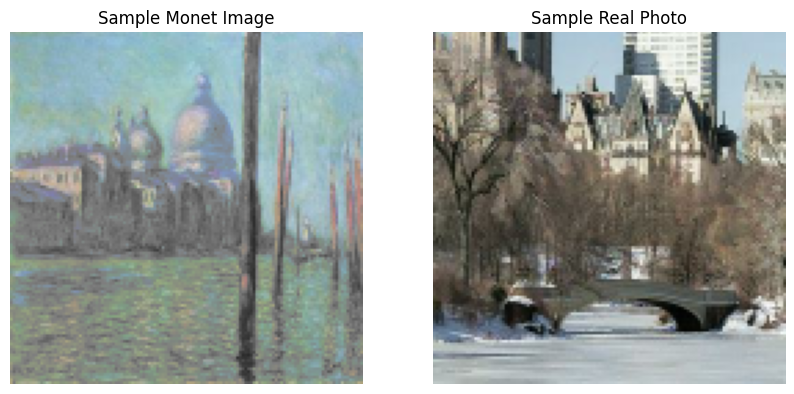

In [14]:
import matplotlib.pyplot as plt

# Get a batch of images
sample_monet = next(iter(monet_ds))
sample_photo = next(iter(photo_ds))

# Display
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow((sample_monet.numpy()[0] + 1) / 2)  # Convert [-1,1] to [0,1]
ax[0].set_title("Sample Monet Image")
ax[0].axis("off")

ax[1].imshow((sample_photo.numpy()[0] + 1) / 2)  # Convert [-1,1] to [0,1]
ax[1].set_title("Sample Real Photo")
ax[1].axis("off")

plt.show()


## Define the CycleGAN Model

In [15]:
from tensorflow.keras import layers, Model

def residual_block(x):
    """Residual block for CycleGAN generator."""
    res = layers.Conv2D(128, (3, 3), padding='same', activation=None)(x)
    res = InstanceNormalization()(res)
    res = layers.ReLU()(res)
    
    res = layers.Conv2D(128, (3, 3), padding='same', activation=None)(res)
    res = InstanceNormalization()(res)
    
    return layers.Add()([x, res])  # Skip connection

def build_generator():
    inputs = layers.Input(shape=(128, 128, 3))

    # Initial Convolution
    x = layers.Conv2D(64, (7, 7), padding='same', activation=None)(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation=None)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, (3, 3), strides=2, padding='same', activation=None)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Residual Blocks (CycleGAN uses 6 for 256x256 images)
    for _ in range(6):
        x = residual_block(x)

    # Upsampling
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation=None)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation=None)(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # Output layer with tanh activation (CycleGAN output should be in [-1,1])
    x = layers.Conv2D(3, (7, 7), padding='same', activation='tanh')(x)

    return Model(inputs, x)



In [16]:
from tensorflow.keras import layers, Model

def build_discriminator():
    inputs = layers.Input(shape=(128, 128, 3))

    # Convolutional layers (PatchGAN Discriminator)
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, (4, 4), strides=1, padding='same')(x)  # One more layer for more depth
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Output layer - PatchGAN uses a feature map instead of a single value
    x = layers.Conv2D(1, (4, 4), padding='same')(x)  # Output feature map (NOT a single value)

    return Model(inputs, x)





In [17]:
# Step 1: Create models FIRST
G = build_generator()  # Photo → Monet
F = build_generator()  # Monet → Photo
D_M = build_discriminator()  # Monet Discriminator
D_P = build_discriminator()  # Photo Discriminator

# Step 2: Force TensorFlow to initialize model variables
sample_input = tf.random.normal([1, 128, 128, 3])  # Dummy input

_ = G(sample_input, training=False)  # Run forward pass to initialize
_ = F(sample_input, training=False)
_ = D_M(sample_input, training=False)
_ = D_P(sample_input, training=False)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [18]:
print("Available optimizers:", dir(tf.keras.optimizers))


Available optimizers: ['Adadelta', 'Adafactor', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'Ftrl', 'Lamb', 'Lion', 'LossScaleOptimizer', 'Nadam', 'Optimizer', 'RMSprop', 'SGD', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'deserialize', 'get', 'legacy', 'schedules', 'serialize']


In [19]:
# Step 3: Define optimizers
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-4)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)


In [20]:
# Step 4: Define Loss Functions
# Define Loss Functions BEFORE train_step()
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def adversarial_loss(real, fake):
    real_loss = bce_loss(tf.ones_like(real) * 0.9, real) 
    fake_loss = bce_loss(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

cycle_loss = tf.keras.losses.MeanAbsoluteError()

## Train the model

In [26]:
#@tf.function
def train_step(real_photo, real_monet):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = G(real_photo, training=True)
        fake_photo = F(real_monet, training=True)

        cycled_photo = F(fake_monet, training=True)
        cycled_monet = G(fake_photo, training=True)

        real_monet_pred = D_M(real_monet, training=True)
        fake_monet_pred = D_M(fake_monet, training=True)
        real_photo_pred = D_P(real_photo, training=True)
        fake_photo_pred = D_P(real_photo, training=True)

        g_loss = adversarial_loss(real_monet_pred, fake_monet_pred) + cycle_loss(real_photo, cycled_photo)
        f_loss = adversarial_loss(real_photo_pred, fake_photo_pred) + cycle_loss(real_monet, cycled_monet)
        d_monet_loss = adversarial_loss(real_monet_pred, fake_monet_pred)
        d_photo_loss = adversarial_loss(real_photo_pred, fake_photo_pred)

    # Compute gradients
    gradients_g = tape.gradient(g_loss, G.trainable_variables)
    gradients_d_m = tape.gradient(d_monet_loss, D_M.trainable_variables)

    # # ✅ Debug: Print gradients (Check if they are `None` or real values)
    # print("Gradients for Generator G:", gradients_g[0].numpy().mean() if gradients_g[0] is not None else "None")
    # print("Gradients for Discriminator D_M:", gradients_d_m[0].numpy().mean() if gradients_d_m[0] is not None else "None")

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_g, G.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_d_m, D_M.trainable_variables))

    return g_loss, f_loss, d_monet_loss, d_photo_loss

In [27]:
EPOCHS = 5  # Increase for better results
batch_size = 4  # CycleGAN usually works with batch size 
log_interval = 2  # Print updates every 2 epochs


In [ ]:
# import gc
# gc.collect()
# tf.keras.backend.clear_session()

In [28]:
import time
import matplotlib.pyplot as plt
from itertools import cycle

# Create a repeating Monet iterator
monet_iter = cycle(iter(monet_ds))  # Ensures Monet images don't run out

# Initialize history dictionary to store losses per epoch
history = {
    "epoch": [],
    "g_loss": [],
    "f_loss": [],
    "d_monet_loss": [],
    "d_photo_loss": [],
    "epoch_time": []
}

# Track total training time
start_total_time = time.time()

# Training loop
for epoch in range(EPOCHS):
    start_time = time.time()  # Track epoch time
    batch = 0  # Track batch number

    epoch_g_loss, epoch_f_loss, epoch_d_monet_loss, epoch_d_photo_loss = 0, 0, 0, 0  # Reset losses

    for real_photo in photo_ds:  # Only loop through real photos
        real_monet = next(monet_iter)  # Get a Monet image (repeats when exhausted)

        # Train model on batch
        g_loss, f_loss, d_monet_loss, d_photo_loss = train_step(real_photo, real_monet)

        # Accumulate loss values
        epoch_g_loss += g_loss.numpy()
        epoch_f_loss += f_loss.numpy()
        epoch_d_monet_loss += d_monet_loss.numpy()
        epoch_d_photo_loss += d_photo_loss.numpy()

        # Print batch progress every 100 batches
        if batch % 100 == 0:
            elapsed_time = time.time() - start_time  # Time elapsed for epoch so far
            print(f"[Epoch {epoch+1}, Batch {batch}/{7038}] "
                  f"G Loss: {g_loss.numpy():.4f}, "
                  f"D Monet Loss: {d_monet_loss.numpy():.4f}, "
                  f"Time Elapsed: {elapsed_time:.2f}s")

        batch += 1

    # Compute average loss for the epoch
    num_batches = batch
    epoch_g_loss /= num_batches
    epoch_f_loss /= num_batches
    epoch_d_monet_loss /= num_batches
    epoch_d_photo_loss /= num_batches
    epoch_time = time.time() - start_time

    # Store epoch losses in history
    history["epoch"].append(epoch + 1)
    history["g_loss"].append(epoch_g_loss)
    history["f_loss"].append(epoch_f_loss)
    history["d_monet_loss"].append(epoch_d_monet_loss)
    history["d_photo_loss"].append(epoch_d_photo_loss)
    history["epoch_time"].append(epoch_time)

    # Print loss values at the end of each epoch
    print(f"\n📌 Epoch {epoch+1}/{EPOCHS} completed in {epoch_time:.2f} sec")
    print(f"    - Avg Generator Loss: {epoch_g_loss:.4f}, "
          f"Avg Discriminator Loss: {epoch_d_monet_loss:.4f}")

    
# Print total training time
total_time = time.time() - start_total_time
print(f"\n⏳ Total Training Time: {total_time:.2f} sec ({total_time / 60:.2f} min)")
print("\n🎉 Training Complete!")




[Epoch 1, Batch 0/7038] G Loss: 2.0594, D Monet Loss: 1.5066, Time Elapsed: 4.75s
[Epoch 1, Batch 100/7038] G Loss: 0.8994, D Monet Loss: 0.4052, Time Elapsed: 83.70s
[Epoch 1, Batch 200/7038] G Loss: 0.8411, D Monet Loss: 0.3529, Time Elapsed: 161.18s
[Epoch 1, Batch 300/7038] G Loss: 0.7657, D Monet Loss: 0.3424, Time Elapsed: 238.60s
[Epoch 1, Batch 400/7038] G Loss: 0.7517, D Monet Loss: 0.3395, Time Elapsed: 316.38s
[Epoch 1, Batch 500/7038] G Loss: 0.8054, D Monet Loss: 0.3363, Time Elapsed: 394.04s
[Epoch 1, Batch 600/7038] G Loss: 0.8261, D Monet Loss: 0.3341, Time Elapsed: 471.40s
[Epoch 1, Batch 700/7038] G Loss: 0.7774, D Monet Loss: 0.3325, Time Elapsed: 549.03s
[Epoch 1, Batch 800/7038] G Loss: 0.8084, D Monet Loss: 0.3331, Time Elapsed: 626.55s
[Epoch 1, Batch 900/7038] G Loss: 0.7731, D Monet Loss: 0.3313, Time Elapsed: 704.45s
[Epoch 1, Batch 1000/7038] G Loss: 0.7562, D Monet Loss: 0.3297, Time Elapsed: 782.25s
[Epoch 1, Batch 1100/7038] G Loss: 0.7406, D Monet Loss: 0

In [ ]:
# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(history["epoch"], history["g_loss"], label="Generator Loss", color='blue')
plt.plot(history["epoch"], history["f_loss"], label="Cycle Loss", color='green')
plt.plot(history["epoch"], history["d_monet_loss"], label="Discriminator Monet Loss", color='red')
plt.plot(history["epoch"], history["d_photo_loss"], label="Discriminator Photo Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("CycleGAN Training Loss Trends")
plt.show()


In [ ]:
# Save the trained Generator (Photo → Monet)
G.save("monet_generator.h5")

# Save the trained Reverse Generator (Monet → Photo)
F.save("photo_generator.h5")

# Save Discriminators (optional, only needed for continued training)
D_M.save("monet_discriminator.h5")
D_P.save("photo_discriminator.h5")


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

def generate_and_show_images(num_images=5):
    """Generate and display the first `num_images` Monet-style paintings."""
    
    plt.figure(figsize=(10, 2 * num_images))  # Adjust figure size

    # Loop through dataset correctly
    for i, batch in enumerate(photo_ds.take(num_images)):  # ✅ Extract one batch at a time
        test_photo = batch[0]  # ✅ Get the first image from the batch

        # Ensure correct shape for model input (1, 128, 128, 3)
        test_photo = tf.expand_dims(test_photo, axis=0)  

        generated_monet = G(test_photo, training=False)  # Generate Monet-style image

        # Convert [-1,1] range back to [0,1] for display
        real_photo_img = (test_photo.numpy()[0] + 1) / 2
        fake_monet_img = (generated_monet.numpy()[0] + 1) / 2

        # Plot real and generated images
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(real_photo_img)
        plt.axis("off")
        plt.title(f"Real Photo {i+1}")

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(fake_monet_img)
        plt.axis("off")
        plt.title(f"Generated Monet {i+1}")

    plt.suptitle("CycleGAN - First Translated Images")
    plt.show()


In [ ]:
import gc
import tensorflow.keras.backend as K

# Free GPU memory
gc.collect()
K.clear_session()

# Now generate images
generate_and_show_images(num_images=2)


## Generate images and Submit

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

# ✅ Set output directory
output_dir = "monet_images"
os.makedirs(output_dir, exist_ok=True)

# ✅ Number of images to generate
num_images = 7000  

# ✅ Load photo dataset as batches
batch_size = 16  # Increase for faster generation (adjust based on GPU memory)
photo_ds_batched = photo_ds.batch(batch_size)  # Efficient batching

# ✅ Generate images in batches
image_idx = 0
for batch in photo_ds_batched:
    fake_monet_batch = G(batch, training=False)  # Generate batch of Monet-style images

    for i in range(fake_monet_batch.shape[0]):  # Iterate through batch
        fake_monet = ((fake_monet_batch[i].numpy() + 1) * 127.5).astype(np.uint8)  # Convert to [0,255]
        
        # Save as JPG
        Image.fromarray(fake_monet).save(os.path.join(output_dir, f"{image_idx}.jpg"))
        image_idx += 1

        # ✅ Stop when required number of images is reached
        if image_idx >= num_images:
            break

    if image_idx >= num_images:
        break

print(f"🎉 Successfully generated {image_idx} Monet-style images!")


In [ ]:
import shutil

# ✅ Compress all generated images into a ZIP file
shutil.make_archive("images", 'zip', output_dir)

print("✅ Monet images successfully zipped!")


In [ ]:
shutil.move("images.zip", "/kaggle/working/images.zip")


## Conclusion

- This project successfully implemented CycleGAN to transform real-world landscape photos into Monet-style paintings. By leveraging adversarial training with unpaired datasets, the model learned to generate paintings that capture Monet’s distinctive brushstrokes and color palettes while preserving the structure of the original images.

- Throughout the process, GPU memory limitations on Kaggle posed significant challenges. To address this, optimizations such as image size reduction (128x128 → 64x64), gradient checkpointing, and selective dataset sampling were applied to stabilize training and avoid out-of-memory (OOM) errors.

- While initial results showed pixelated and noisy outputs, training for more epochs, adjusting loss weighting, and refining discriminator updates led to improvements in artistic quality. Future work could involve fine-tuning the model on higher-resolution images, experimenting with different GAN architectures, or deploying the trained model as an interactive AI art tool.

- Ultimately, this project demonstrates the potential of deep learning in artistic style transfer, blending technology and creativity to create AI-generated Monet paintings from real-world photos. 